# Example analysis of a PPG waveform using the vital_sqi package

The following notebook shows an example of PPG waveform processing using the vital_sqi package. The aim of the package is to automate signal quality classification for PPG waveforms. It is achieved by computing various signal quality indices for each signal segment and using them to form a decision. 

## The pipeline can be briefly summarized as follows:
1. Load dataset under analysis
2. Preprocess and segment the dataset
3. Compute SQI for each dataset segment
4. Make decision for each segment

## Global Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import vital_sqi

### Start by importing the signal via the PPG_reader function

The function expects a .csv or similar data format with named columns. The column names are used to separate between data column, timestamp columns and any additional information columns.
This returns a SignalSQI class that is compatible with other vital_sqi package functions, the main class members of interest are:
* signals:         an ndarray of shape (m, n) where m is the number of rows and n is the number of channels of the signal
* sqi_indexes:     an ndarray of shape (m, n) where m is the number of signal segments, n is the number of SQIs.
* sampling_rate:   sampling rate in hertz (Hz)


(23998,)


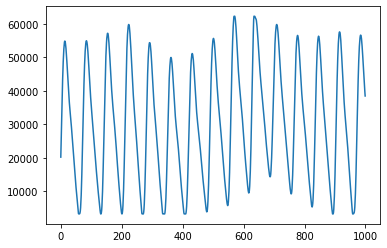

In [2]:
from vital_sqi.data.signal_io import PPG_reader

file_name = "ppg_smartcare.csv"
ppg_data = PPG_reader(os.path.join("../tests/test_data",file_name),
                      signal_idx=['PLETH'],
                      timestamp_idx= ['TIMESTAMP_MS'],
                      info_idx=['SPO2_PCT','PULSE_BPM','PERFUSION_INDEX'], 
                      timestamp_unit='ms', sampling_rate=100, start_datetime=None)

#We have loaded a single data column, therefore we only have 1D timeseries
print(ppg_data.signals.shape)
#Plot a random 10s segment of the signal
s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals[10000:11000])
plt.show()

### Split dataset into individual 30s segments

In this example, the sampling rate is 100 Hz, therefore a 30s segment will have 3,000 samples. We want to remove 24s (0.4 minutes) from both the start and the end. The original signal was 23998 samples long. Subtracting 2,400 from both start and end leaves us with 19,198 samples. Unfortunately, this is not easily divisble by 3000 and therefore we lose another1,198 samples from the end. Resulting in 6 segments of 3,000 samples each.

In [3]:
ppg_data.split_to_segments(minute_remove=0.4, segment_duration=30)
print(ppg_data.signals.shape)

(6, 3000)


### Filter each segment by a band pass filter

The filter_preprocess function applies two digital filters in succession. First high-pass filter followed by a low-pass. The touples used as function parameters stand for cutoff frequency and filter order respectively. Finally, a plot in this example shows the filtered signal centered around 0 as expected.

(6, 3000)


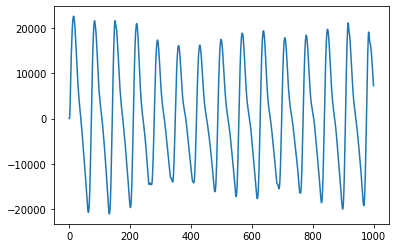

In [4]:
ppg_data.filter_preprocess(hp_cutoff_order=(1, 1), lp_cutoff_order=(20, 4), filter_type='butter')
print(ppg_data.signals.shape)

s = np.arange(0,1000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals[0][0:1000])
plt.show()

### Example peak detection on one segment
Using the Billauer peak detector we can illustrate the output of the peak detector

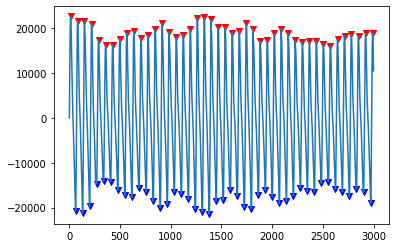

In [5]:
from vital_sqi.common.rpeak_detection import PeakDetector

detector = PeakDetector()
peak_list, trough_list = detector.ppg_detector(ppg_data.signals[0], 7)

s = np.arange(0,3000,1)
fig, ax = plt.subplots()
ax.plot(s, ppg_data.signals[0])
if len(peak_list)!=0:
    ax.scatter(peak_list,ppg_data.signals[0][peak_list],color="r",marker="v")
if len(trough_list)!=0:
    ax.scatter(trough_list,ppg_data.signals[0][trough_list],color="b",marker="v")
plt.show()

### Compute array of SQI's

In [6]:
ppg_data.compute_all_SQI(primary_peakdet=7, secondary_peakdet=2, template_type=0)
print(ppg_data.sqi_indexes)

43
[0.0658026325691156, 0.25072305783400634, 0.22443680025229687, 0.15526319384194648, 0.13095976794012582, 0.11690420871024661, 0.09714785519089573, 0.2462585633366466, 0.15648967915511094, 0.09394376993759987, 0.09272061670569341, 0.08830595245768046, 0.0027099884383428373, 0.1150398996229054, 0.1544024108551555, 0.06594440558165439, 0.11217231101419053, 0.07102533333460714, 0.07938445488637966, 0.14317505462981894, 0.24661393123716738, 0.16868959081695034, 0.09413711759824028, 0.10467045858632662, -0.027905912319658537, 0.05237978808074899, 0.08158081918132438, 0.09860487435273547, 0.05664623517611788, 0.05610607226354105, 0.01702214378486178, 0.06000972034380336, 0.10997289957663657, 0.16885964837817632, 0.17768533723735855, 0.15282634676093187, 0.15694424924086683, 0.12162781870840501, 0.16998012787558167, 0.17284930058520817]
43
[0.12017425005583629, 0.182918922489581, 0.225381013242706, 0.1838408062525732, 0.13785313000001173, 0.11667882072370894, 0.09584168732459225, 0.16378271